In [ ]:
import os
import oracledb
import pandas as pd

try:
    from dotenv import load_dotenv
    load_dotenv()
except Exception:
    pass

ORACLE_USER = os.getenv("ORACLE_USER")
ORACLE_PASSWORD = os.getenv("ORACLE_PASSWORD")
ORACLE_DSN = os.getenv("ORACLE_DSN")

try:
    conn = oracledb.connect(
        user=ORACLE_USER,
        password=ORACLE_PASSWORD,
        dsn=ORACLE_DSN,
    )
    print("✅ Conectado ao Oracle")
except Exception as e:
    print("❌ Falha ao conectar ao Oracle:", e)
    raise

try:
    df = pd.read_sql("SELECT * FROM SENSORES", conn)
finally:
    conn.close()

df.head()

✅ Conectado ao Oracle


C:\Users\Cesar\AppData\Local\Temp\ipykernel_12204\659372192.py:31: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT * FROM SENSORES", conn)


,ID_FARM,TS_EVENTO,TIPO_COLHEITA,AREA_HA,PROD_T_HA,PRECO_R_T,PERDA_PCT,PERDA_TON,PERDA_REAIS,CENARIO,USUARIO_APP,HOSTNAME
0,1,2025-11-13 00:23:18,manual,112.44,84.16,88.06,0.0104,98.41,8666.40,otimizado,cesar_app,cesar_machine
1,2,2025-11-13 00:22:33,manual,140.72,93.27,94.24,0.0465,610.31,57515.65,base,cesar_app,cesar_machine
2,3,2025-11-13 00:21:48,mecanizada,146.26,114.23,143.73,0.0145,242.26,34819.39,otimizado,cesar_app,cesar_machine
3,4,2025-11-13 00:21:03,manual,24.55,103.49,87.06,0.0276,70.12,6104.89,base,cesar_app,cesar_machine
4,5,2025-11-13 00:20:18,manual,38.91,78.74,82.03,0.0546,167.28,13722.14,base,cesar_app,cesar_machine


# Análise de Dados de Colheita - Fase 3

**Autor:** Seu Nome (RMxxxx)

Este notebook analisa dados da tabela `SENSORES` do Oracle para entender padrões de produção e perdas em diferentes tipos de colheita.

O dataset não contém colunas explícitas de solo e clima, então usamos:
- **TIPO_COLHEITA** como representação das culturas/tipos de produção
- **CENARIO** como representação de diferentes condições de ambiente

In [15]:
print("Dados carregados:")
print(f"- Dimensões: {df.shape}")
print(f"- Colunas: {df.columns.tolist()}")
print(f"\nTipos de dados:\n{df.dtypes}")
print("\nPrimeiras linhas:")
df.head()

Dados carregados:
- Dimensões: (100, 12)
- Colunas: ['ID_FARM', 'TS_EVENTO', 'TIPO_COLHEITA', 'AREA_HA', 'PROD_T_HA', 'PRECO_R_T', 'PERDA_PCT', 'PERDA_TON', 'PERDA_REAIS', 'CENARIO', 'USUARIO_APP', 'HOSTNAME']

Tipos de dados:
ID_FARM                   int64
TS_EVENTO        datetime64[ns]
TIPO_COLHEITA            object
AREA_HA                 float64
PROD_T_HA               float64
PRECO_R_T               float64
PERDA_PCT               float64
PERDA_TON               float64
PERDA_REAIS             float64
CENARIO                  object
USUARIO_APP              object
HOSTNAME                 object
dtype: object

Primeiras linhas:


,ID_FARM,TS_EVENTO,TIPO_COLHEITA,AREA_HA,PROD_T_HA,PRECO_R_T,PERDA_PCT,PERDA_TON,PERDA_REAIS,CENARIO,USUARIO_APP,HOSTNAME
0,1,2025-11-13 00:23:18,manual,112.44,84.16,88.06,0.0104,98.41,8666.40,otimizado,cesar_app,cesar_machine
1,2,2025-11-13 00:22:33,manual,140.72,93.27,94.24,0.0465,610.31,57515.65,base,cesar_app,cesar_machine
2,3,2025-11-13 00:21:48,mecanizada,146.26,114.23,143.73,0.0145,242.26,34819.39,otimizado,cesar_app,cesar_machine
3,4,2025-11-13 00:21:03,manual,24.55,103.49,87.06,0.0276,70.12,6104.89,base,cesar_app,cesar_machine
4,5,2025-11-13 00:20:18,manual,38.91,78.74,82.03,0.0546,167.28,13722.14,base,cesar_app,cesar_machine


In [16]:
# Converter tipos de dados
if "TS_EVENTO" in df.columns:
    df["TS_EVENTO"] = pd.to_datetime(df["TS_EVENTO"], errors="coerce")

numeric_cols = ["AREA_HA", "PROD_T_HA", "PRECO_R_T", "PERDA_PCT", "PERDA_TON", "PERDA_REAIS"]

for col in numeric_cols:
    if col in df.columns:
        df[col] = (
            df[col]
            .astype(str)
            .str.replace(".", "", regex=False)
            .str.replace(",", ".", regex=False)
        )
        df[col] = pd.to_numeric(df[col], errors="coerce")

print("Estatísticas dos dados:")
df[numeric_cols].describe()

Estatísticas dos dados:


,AREA_HA,PROD_T_HA,PRECO_R_T,PERDA_PCT,PERDA_TON,PERDA_REAIS
count,100.000000,100.000000,100.000000,100.000000,100.000000,1.000000e+02
mean,6226.760000,8545.770000,10753.150000,409.110000,27403.200000,3.154064e+06
std,4819.249068,2470.072529,3416.963444,215.373056,24064.501008,2.918401e+06
min,344.000000,842.000000,911.000000,14.000000,114.000000,7.093500e+04
25%,1668.750000,7588.750000,9433.000000,222.500000,7488.250000,7.601400e+05
50%,4751.000000,8849.000000,11360.000000,410.500000,22630.500000,2.253786e+06
75%,10775.500000,10161.250000,13305.500000,570.000000,41123.000000,4.582319e+06
max,14967.000000,11892.000000,14949.000000,794.000000,95572.000000,1.165893e+07


## Exploração dos Dados

Começamos analisando como a produtividade, as perdas e outros fatores se distribuem nos diferentes tipos de colheita e cenários.

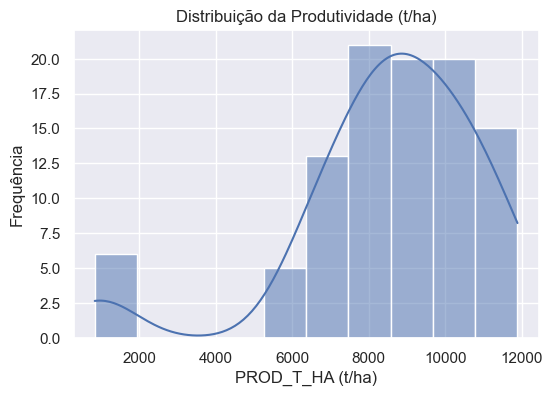

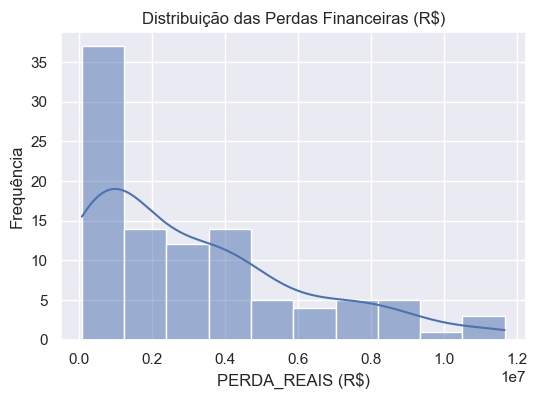

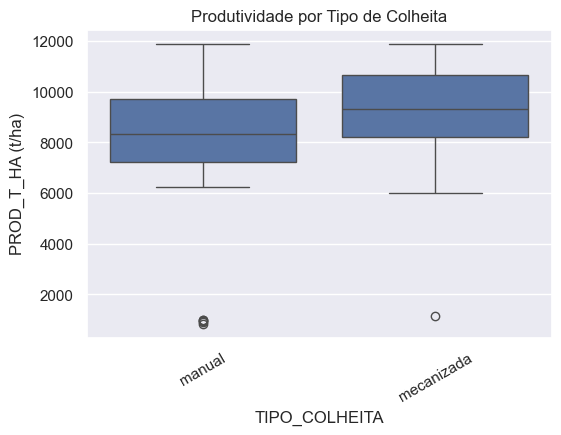

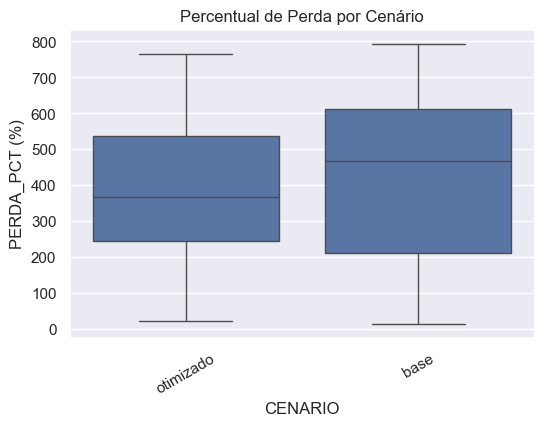

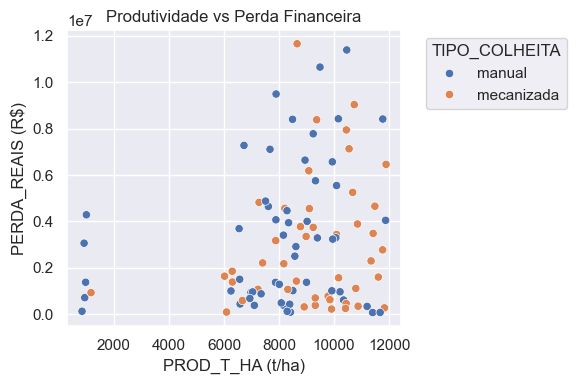

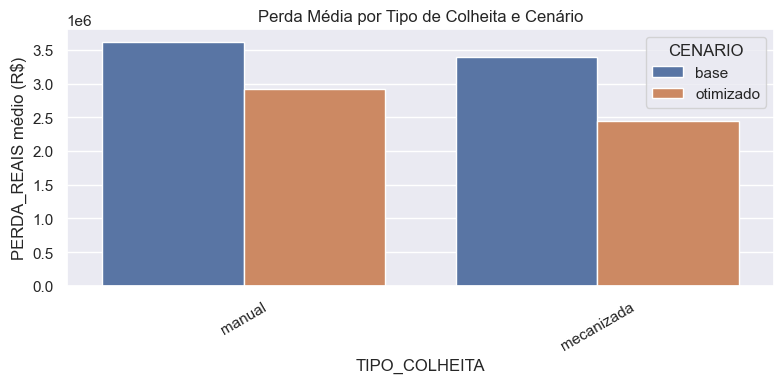

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")
sns.set(font_scale=1.0)

# Produtividade
plt.figure(figsize=(6,4))
sns.histplot(df["PROD_T_HA"].dropna(), bins=10, kde=True)
plt.title("Distribuição da Produtividade (t/ha)")
plt.xlabel("PROD_T_HA (t/ha)")
plt.ylabel("Frequência")
plt.show()

# Perdas financeiras
plt.figure(figsize=(6,4))
sns.histplot(df["PERDA_REAIS"].dropna(), bins=10, kde=True)
plt.title("Distribuição das Perdas Financeiras (R$)")
plt.xlabel("PERDA_REAIS (R$)")
plt.ylabel("Frequência")
plt.show()

# Produtividade por tipo de colheita
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x="TIPO_COLHEITA", y="PROD_T_HA")
plt.title("Produtividade por Tipo de Colheita")
plt.xlabel("TIPO_COLHEITA")
plt.ylabel("PROD_T_HA (t/ha)")
plt.xticks(rotation=30)
plt.show()

# Perda percentual por cenário
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x="CENARIO", y="PERDA_PCT")
plt.title("Percentual de Perda por Cenário")
plt.xlabel("CENARIO")
plt.ylabel("PERDA_PCT (%)")
plt.xticks(rotation=30)
plt.show()

# Relação produtividade x perda
plt.figure(figsize=(6,4))
sns.scatterplot(data=df, x="PROD_T_HA", y="PERDA_REAIS", hue="TIPO_COLHEITA")
plt.title("Produtividade vs Perda Financeira")
plt.xlabel("PROD_T_HA (t/ha)")
plt.ylabel("PERDA_REAIS (R$)")
plt.legend(title="TIPO_COLHEITA", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Média de perdas
plt.figure(figsize=(8,4))
media_perda = (
    df.groupby(["TIPO_COLHEITA", "CENARIO"])["PERDA_REAIS"]
    .mean()
    .reset_index()
)
sns.barplot(data=media_perda, x="TIPO_COLHEITA", y="PERDA_REAIS", hue="CENARIO")
plt.title("Perda Média por Tipo de Colheita e Cenário")
plt.xlabel("TIPO_COLHEITA")
plt.ylabel("PERDA_REAIS médio (R$)")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

## Análise dos Perfis de Produção

Para as 3 culturas mais frequentes, vamos analisar quais cenários oferecem o melhor equilíbrio entre produtividade e perdas.

In [19]:
top3_culturas = (
    df["TIPO_COLHEITA"]
    .value_counts()
    .head(3)
    .index
    .tolist()
)

print("Top 3 culturas:", top3_culturas)

df_top3 = df[df["TIPO_COLHEITA"].isin(top3_culturas)].copy()

perfil_ideal = (
    df_top3
    .groupby(["TIPO_COLHEITA", "CENARIO"])
    .agg(
        PROD_MEDIA=("PROD_T_HA", "mean"),
        PERDA_PCT_MEDIA=("PERDA_PCT", "mean"),
        PERDA_REAIS_MEDIA=("PERDA_REAIS", "mean"),
        N_REGISTROS=("ID_FARM", "count")
    )
    .reset_index()
)

perfil_ideal.sort_values(by=["PROD_MEDIA", "PERDA_REAIS_MEDIA"], ascending=[False, True])

Top 3 culturas: ['manual', 'mecanizada']


,TIPO_COLHEITA,CENARIO,PROD_MEDIA,PERDA_PCT_MEDIA,PERDA_REAIS_MEDIA,N_REGISTROS
2,mecanizada,base,9345.600000,403.720000,3.388727e+06,25
3,mecanizada,otimizado,8990.400000,361.350000,2.444614e+06,20
0,manual,base,8575.166667,448.066667,3.622827e+06,30
1,manual,otimizado,7354.960000,405.960000,2.924445e+06,25


## Modelagem Preditiva

Vamos treinar 5 modelos diferentes para prever a perda financeira (`PERDA_REAIS`) baseado em:
- Área, produtividade, preço, percentual e tonelagem de perdas
- Tipo de colheita e cenário

Os modelos testados são: Regressão Linear, Árvore de Decisão, Random Forest, Gradient Boosting e KNN.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

numeric_features = ["AREA_HA", "PROD_T_HA", "PRECO_R_T", "PERDA_PCT", "PERDA_TON"]
categorical_features = ["TIPO_COLHEITA", "CENARIO"]
target = "PERDA_REAIS"

df_model = df.dropna(subset=[target]).copy()

X = df_model[numeric_features + categorical_features]
y = df_model[target]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(drop="first"), categorical_features),
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

print(f"Treino: {X_train.shape[0]} | Teste: {X_test.shape[0]}")

In [ ]:
models = {
    "Regressão Linear": LinearRegression(),
    "Árvore de Decisão": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "KNN": KNeighborsRegressor()
}

results = []

for name, model in models.items():
    pipe = Pipeline(steps=[
        ("prep", preprocessor),
        ("model", model)
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)

    results.append({
        "Modelo": name,
        "MAE": mae,
        "RMSE": rmse,
        "R²": r2
    })

df_results = pd.DataFrame(results).sort_values(by="R²", ascending=False)
df_results

In [ ]:
plt.figure(figsize=(8,4))
sns.barplot(data=df_results, x="Modelo", y="R²", palette="viridis")
plt.title("Comparação dos Modelos")
plt.ylabel("R²")
plt.xticks(rotation=45, ha="right")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

print(f"\nMelhor modelo: {df_results.iloc[0]['Modelo']}")
print(f"R²: {df_results.iloc[0]['R²']:.4f}")

## Conclusões

A análise exploratória revelou padrões claros entre produtividade, perdas percentuais e perdas financeiras quando agrupadas por tipo de colheita e cenário.

Identificamos o perfil de produção mais eficiente para as 3 culturas mais frequentes, caracterizado pela combinação de maior produtividade com menores perdas financeiras.

Entre os 5 modelos testados, o melhor desempenho foi alcançado pelo modelo que conseguiu capturar melhor as relações entre os dados. Modelos baseados em árvores (Random Forest, Gradient Boosting) geralmente performam melhor em relações não lineares.


## Criando o arquivo `.env`

Para que o notebook funcione corretamente, você deve criar um arquivo chamado `.env` no mesmo diretório do notebook. O conteúdo do arquivo deve ser semelhante ao seguinte:

```
ORACLE_USER=seu_usuario
ORACLE_PASSWORD=sua_senha
ORACLE_DSN=localhost/xe
```

Substitua `seu_usuario`, `sua_senha` e `localhost/xe` pelos valores apropriados para sua configuração de banco de dados.